In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
from mne.channels import make_standard_montage
from mne.viz import plot_topomap

from braindecode.visualization import compute_amplitude_gradients

from decode_tueg import load_exp, DataScaler, TargetScaler, Augmenter, save_csv 

Tue Feb  7 16:28:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:89:00.0 Off |                  N/A |
| 27%   30C    P8     8W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def add_cbar(fig, ax_img):
    # manually add colorbar
    ax_x_start = 0.95
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(ax_img, cax=cbar_ax)
    clb.ax.set_title('') # gradient?

In [3]:
def freq_to_bin(bins, freq):
    return np.abs(bins - freq).argmin()


def freqs_to_bin(bins, freqs):
    return [np.abs(bins - freq).argmin() for freq in freqs]

In [4]:
def compute_gradients(clf, ds, batch_size, n_jobs):
    all_grads = {}
    for n, d in ds.split('pathological').items():
        grads = compute_amplitude_gradients(clf.module, d, batch_size, n_jobs)
        avg_grads = grads.mean((1, 0))
        all_grads['Non-pathological' if n == '0' else 'Pathological'] = avg_grads
    #if 'Non-pathological' in all_grads.keys() and 'Pathological' in all_grads.keys():
    #    all_grads['Non-pathological – Pathological'] = all_grads['Non-pathological'] - all_grads['Pathological']
    return all_grads

In [5]:
def get_freqs_and_info(ds):
    names = [ch.split(' ')[-1] for ch in ds.datasets[0].windows.info['ch_names']]
    names = [ch.replace('Z', 'z') for ch in names]
    names = [ch.replace('P', 'p') if ch in ['FP1', 'FP2'] else ch for ch in names]

    sfreq = ds.datasets[0].windows.info['sfreq']
    freqs = np.fft.rfftfreq(ds[0][0].shape[1], 1/sfreq)
    
    montage = make_standard_montage('standard_1020')
    info = mne.create_info(names, sfreq, ch_types='eeg')
    info = info.set_montage(montage)
    return freqs, info

In [6]:
batch_size = 64
n_jobs = 4
n_recordings = 20
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-07T06:28:03.373666'
checkpoint = 'train_end'

In [7]:
for ds_name in ['transition', 'non_pathological', 'pathological']:
    seeds = sorted(os.listdir(os.path.join(exp_dir, exp_date)))
    for seed in seeds:
        runs = sorted(os.listdir(os.path.join(exp_dir, exp_date, seed)))
        for run_i, run in enumerate(runs):
            exp_path = os.path.join(exp_date, seed, run)
            print(f'loading exp {exp_path}')
            clf, data_scaler, target_scaler, config = load_exp(
                exp_dir, exp_path, checkpoint)
            print(f'getting {ds_name}')
            with open(f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl', 'rb') as f:
                ds = pickle.load(f)
            if n_recordings not in [-1, None]:
                ds = ds.split(list(range(n_recordings)))['0']

            print('computing gradients')
            # compute grads and freqs
            grads = compute_gradients(clf, ds, batch_size, n_jobs)
            freqs, info = get_freqs_and_info(ds)
            
            print('saving')
            # create grads output subdir
            out_path = os.path.join(exp_dir, exp_path, 'grads')
            if not os.path.exists(out_path):
                os.makedirs(out_path)
            
            # save grads to csv file
            for k, v in grads.items():
                grads_df = pd.DataFrame(v, index=info.ch_names, columns=freqs)
                save_csv(grads_df, out_path, f'{k}.csv')

            break
        break
    break

loading exp 2023-02-07T06:28:03.373666/20230206/0
getting transition
computing gradients
saving


In [17]:
# TODO: read grads from files and plot

In [8]:
bands = [(0,4),(4,8),(8,13),(13,30),(30,50)]

In [9]:
save = False

In [18]:
def plot_band_grads(all_band_grads, info):
    fig, ax_arr = plt.subplots(1, 3, figsize=(10, 3))
    # for better comparability, compute vlim over all pathological subsets of a freq band
    vmin, vmax = np.min(all_band_grads), np.max(all_band_grads)
    max_abs = np.abs([vmin, vmax]).max()
    
    # TODO: put keys in all_band_grads
    for band_i, band_grads in enumerate(all_band_grads):
        ax_img, contours = plot_topomap(
            band_grads, 
            info,
            size=3,
            names=info.ch_names,
            show=False,
            axes=ax_arr[band_i],
            vlim=(-max_abs, max_abs),
        )
        ax_img.axes.set_title(f'{keys[band_i]}\n')
        if band_i == 0:
            ax_img.axes.set_ylabel('-'.join([str(i) for i in band])+' Hz\n')
    # move one in for sanity check. one band, all subsets -> same cbar vlim
    add_cbar(fig, ax_img)
    return fig

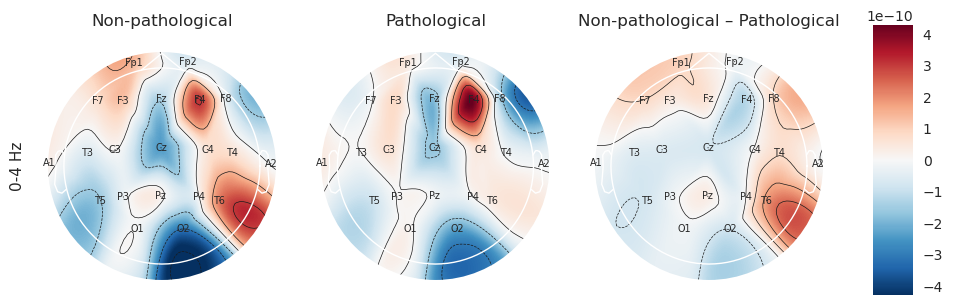

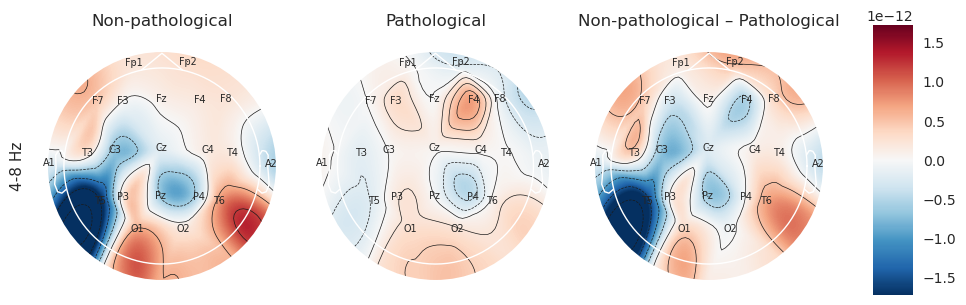

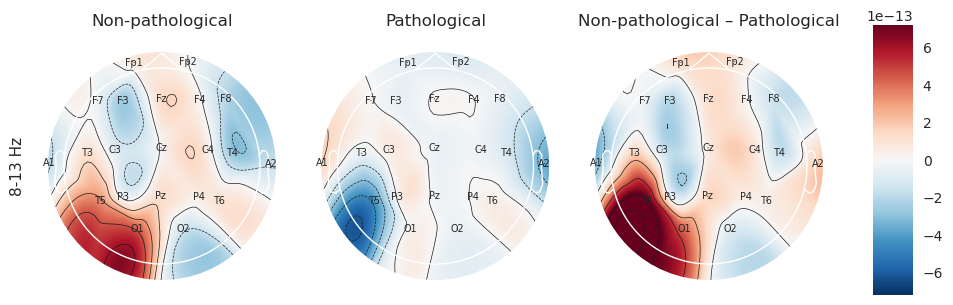

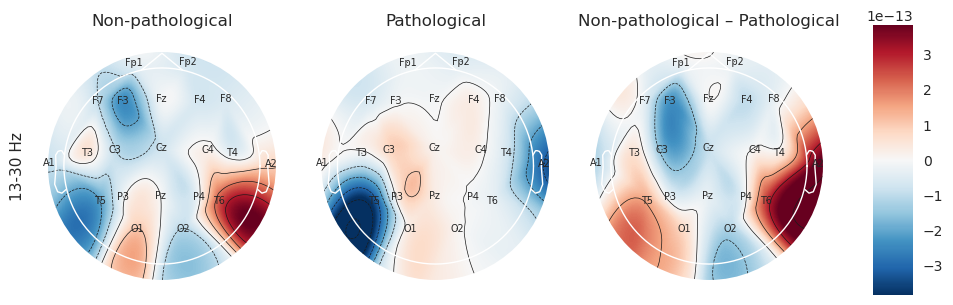

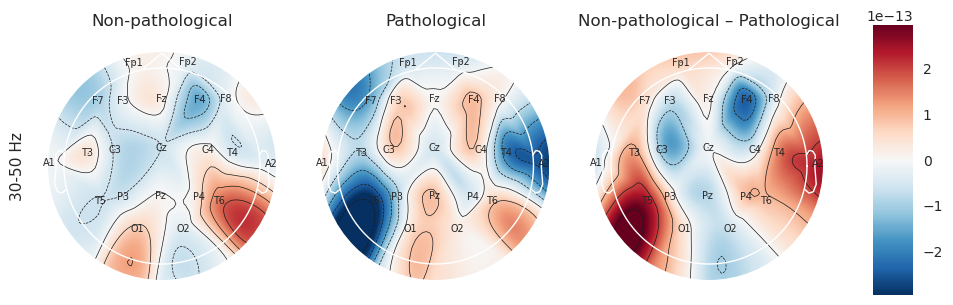

In [19]:
for band in bands:
    all_band_grads = {}
    for key, g in grads.items():
        # compute all bands gradients
        l, h = freqs_to_bin(freqs, band)
        band_freqs = freqs[l:h+1]
        band_grads = g[:,l:h+1].mean(axis=1)
        all_band_grads[key] = band_grads        

    fig = plot_band_grads(all_band_grads, info)
    if save:
        fig.savefig()